In [1]:
import numpy as np

%matplotlib inline

In [2]:
import os
import sys

# Hacky fix to import from parent directory
path_to_this_notebook = os.path.abspath('../')
path_to_project = path_to_this_notebook[:path_to_this_notebook.find('note')]
sys.path.append(path_to_project)

In [3]:
from src.samplers.load_samplers import load_samplers
from src.environments.create_env import create_env
from src.optimization.heuristic_greedy import compute_greedy_heuristic
from src.optimization.deterministic_solution import compute_deterministic_solution

from src.utils.plot_results import plot_results

### Config and data loading

In [3]:
config = {'path_to_data': path_to_project + '/data/', 
          't0_hr': 6., # When the episode start (default value 6AM)
          'dt_min': 30, # Timestep size
          'ev_dt_min': 60, # Timestep size for EV arrivals
          'ev_sampling_dt_min': 60,  # How EV sessions are sampled from the data
          'apply_gaussian_noise': False, # Make data noisy
          'ev_utility_coef_mean': 1, # Mean value of the utility coefficient for the EVs
          'ev_utility_coef_scale': 0.13, # STD of the utility coefficient for the EVs
          'days_per_month_train': 20, # Days per month for training 
          'ev_session_months_train': ['01', 
        #   '02', '03', '04', '06', '07', '08', '09', '10', '11',
          ],
           # Months to sample EV sessions for training 
          'grid_to_use': 'ieee16', # What grid topology to use. Now supports only IEEE16. 
          'ev_session_months_test': ['05', '12'], # Months to sample EV sessions for test 
          'n_ps_pvs': 4, # Amount of solar panels that use PecanStreet data
          'n_canopy_pvs': 0, # Amount of solar panels that use canopy data
          'canopy_pv_rated_power': 250, # Rated power of these panels
          'n_loads': 0, # Amount of inflexible loads
          'n_feeders': 1, # Amount of feeders
          'n_ev_chargers': 4, # Amount of EV chargers
          
          'ps_pvs_rated_power': 4, # Rated power of these panels
          'avg_evs_per_day': 3.5, # Scaling of the EV arrival rate
          'feeder_p_min': -5, # Capacity of the feeders
          'g': 4, # Conductance of each line
          'i_max': 25, # Capacity of each line

          # New and improved config options
          'environment_type': 'gym', 
          'use_constraint_projection': False,
          'normalize_environment_outputs': True,
          'use_rescaled_actions': True,

          "violations_in_reward": False
          }

In [4]:
# Preload samplers, it is necessary to avoid re-loading data each time env is created
(ps_samplers_dict, ps_metadata, canopy_sampler, canopy_metadata,
 price_sampler, price_metadata, ev_sampler, elaadnl_metadata) = load_samplers(config)

{'path_to_data': '/Users/fransdeboer/Projects/RL-EVCP//data/', 't0_hr': 6.0, 'dt_min': 30, 'ev_dt_min': 60, 'ev_sampling_dt_min': 60, 'apply_gaussian_noise': False, 'ev_utility_coef_mean': 1, 'ev_utility_coef_scale': 0.13, 'days_per_month_train': 20, 'ev_session_months_train': ['01'], 'grid_to_use': 'ieee16', 'ev_session_months_test': ['05', '12'], 'n_ps_pvs': 4, 'n_canopy_pvs': 0, 'canopy_pv_rated_power': 250, 'n_loads': 0, 'n_feeders': 1, 'n_ev_chargers': 4, 'ps_pvs_rated_power': 4, 'avg_evs_per_day': 3.5, 'feeder_p_min': -5, 'g': 4, 'i_max': 25, 'environment_type': 'gym', 'use_constraint_projection': False, 'normalize_environment_outputs': True, 'use_rescaled_actions': True, 'violations_in_reward': False}
loading ps meta data
loading ps solar data
loading arrivals data
loading price data
loading done
creating samplers
saving cache


In [11]:
# Create environment
env = create_env(config, ps_samplers_dict, ps_metadata, canopy_sampler, canopy_metadata,
                 price_sampler, price_metadata, ev_sampler, elaadnl_metadata)

### Greedy

Reward = 182.07


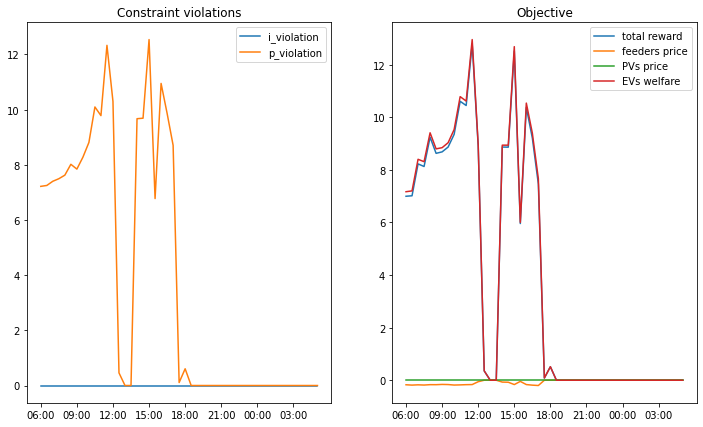

In [12]:
# Greedy heuristic which solves single-timestep OPF using lossless model
# It gets higher reward, but violates the power-flow constraints. 
env.use_rescaled_actions = False
env.normalize_outputs = False

np.random.seed(2204672)
env.reset(episode_index=24, train=True)

results_list = []
total_reward = 0

while not env.done:
    # print('t=%s' % env.t_str)

    state = env.compute_current_state()
    reshaped_state = state.reshape(-1, env.n_devices)
    p_lbs_t, p_ubs_t, v_lbs_t, v_ubs_t, u_t = reshaped_state[0], reshaped_state[1], reshaped_state[2], reshaped_state[3], reshaped_state[4]
    p, v, model = compute_greedy_heuristic(u_t, p_lbs_t, p_ubs_t, v_lbs_t, v_ubs_t, 
                                           env.conductance_matrix, env.i_max_matrix, 
                                           lossless=True, tee=False)
    action = np.concatenate((p,v), axis=0)
    _, _, _, result = env.step(action)
    total_reward += result['reward']
    results_list.append(result)
    
print('Reward = %.2f' % total_reward)
plot_results(env, results_list, figsize=(12, 7))



### Deterministic

Reward = 182.44


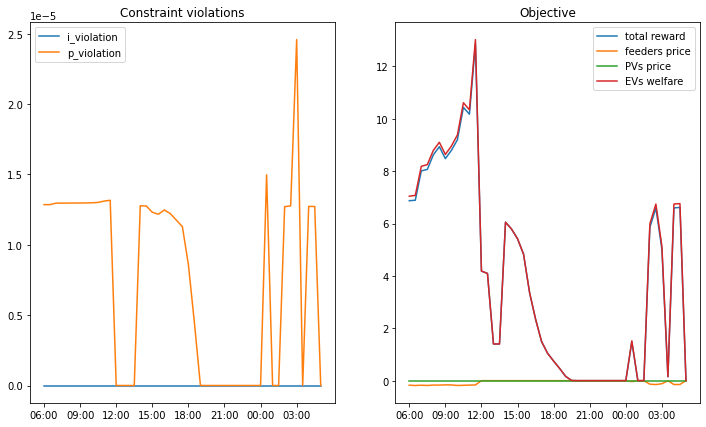

In [13]:
np.random.seed(2204672)
env.reset(episode_index=24, train=True)

p_lbs, p_ubs, v_lbs, v_ubs, u, evs_dict = env.compute_full_state()
p_det, v_det, model = compute_deterministic_solution(env.dt_min, evs_dict, u[0], p_lbs[0], 
                                                     p_ubs[0], v_lbs[0], v_ubs[0], 
                                                     env.conductance_matrix, env.i_max_matrix,
                                                     lossless=False, tee=False)
                                                     
results_list = []
total_reward = 0

while not env.done:
    action = np.concatenate((p_det[env.t_ind], v_det[env.t_ind]), axis=0)
    _, _, _, result = env.step(action)

    total_reward += result['reward']
    results_list.append(result)

print('Reward = %.2f' % total_reward)
plot_results(env, results_list, figsize=(12, 7))

### Optimal without constraints

Reward = 222.85


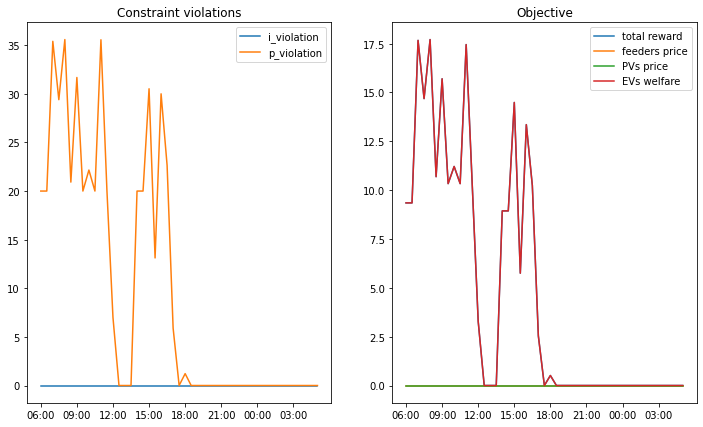

In [14]:
np.random.seed(2204672)
env.reset(episode_index=24, train=True)

results_list = []
total_reward = 0
i_violations = 0
p_violations = 0

while not env.done:
    state = env.compute_current_state()
    reshaped_state = state.reshape(-1, env.n_devices)
    p_lbs_t, p_ubs_t, v_lbs_t, v_ubs_t, u_t = reshaped_state[0], reshaped_state[1], reshaped_state[2], reshaped_state[3], reshaped_state[4]
    action = np.concatenate((p_ubs_t,v_ubs_t), axis=0)


    _, _, _, result = env.step(action)
    total_reward += result['reward']
    results_list.append(result)
    
print('Reward = %.2f' % total_reward)
plot_results(env, results_list, figsize=(12, 7))


In [15]:
actions = [[-0.31295484, -0.93177915, -0.78404766,  0.69558907, -0.3344391 ,
        0.253116  ,  0.90845853,  0.93425584, -0.13875069, -0.9187717 ,
        0.9533119 , -0.5713806 ,  0.3919582 , -0.88513327, -0.3449788 ,
       -0.7644585 , -0.58768487, -0.45421213, -0.4844711 ,  0.8800005 ,
       -0.946432  , -0.94270045, -0.7176822 ,  0.368858  , -0.49341774,
        0.62167174,  0.78777254, -0.41483593,  0.9461721 , -0.51973546,
        0.02704639, -0.89172024, -0.921454  , -0.81545585, -0.6704702 ,
        0.47931477, -0.20706952, -0.8725368 ,  0.98743355, -0.32599902,
        0.88987225, -0.88594383, -0.57191265,  0.94110346],
[-0.5091681 , -0.99041355, -0.93927395,  0.86466604, -0.45674264,
        0.32954758,  0.9847015 ,  0.9896698 , -0.19515176, -0.98737764,
        0.9944955 , -0.7513567 ,  0.6282685 , -0.97410613, -0.4537671 ,
       -0.90926373, -0.81235844, -0.6839287 , -0.7081537 ,  0.97484756,
       -0.99303067, -0.99177724, -0.9035937 ,  0.51595503, -0.71562576,
        0.8045884 ,  0.9254045 , -0.6277565 ,  0.9925794 , -0.6868839 ,
       -0.02620765, -0.9774094 , -0.9871179 , -0.95024806, -0.8480667 ,
        0.65270853, -0.32941082, -0.9701891 ,  0.9993161 , -0.4728625 ,
        0.9815132 , -0.97622573, -0.7671297 ,  0.99325836], 
[-0.6018258 , -0.99688673, -0.97132885,  0.9168292 , -0.5191355 ,
        0.3708333 ,  0.9945458 ,  0.99643105, -0.22640632, -0.9956749 ,
        0.9983791 , -0.8211345 ,  0.7267413 , -0.9890589 , -0.509404  ,
       -0.94844586, -0.88415366, -0.7746957 , -0.7946214 ,  0.98983103,
       -0.9978292 , -0.9972937 , -0.94941396,  0.58776855, -0.8010326 ,
        0.86907685,  0.95982265, -0.7191554 ,  0.9976084 , -0.75818616,
       -0.05665158, -0.9908673 , -0.9954388 , -0.97693664, -0.9047233 ,
        0.7285023 , -0.39416298, -0.98719096,  0.99986917, -0.5464983 ,
        0.9934266 , -0.9904148 , -0.83933413,  0.99804854], 
[-0.63533247, -0.99802727, -0.9789026 ,  0.9319066 , -0.5429809 ,
        0.38694194,  0.9964135 ,  0.99768007, -0.2386835 , -0.99719864,
        0.99901235, -0.8439738 ,  0.76004755, -0.99228734, -0.53083026,
       -0.95906854, -0.9051522 , -0.8044228 , -0.82283896,  0.9929612 ,
       -0.9986464 , -0.99827415, -0.9611885 ,  0.6145131 , -0.8286235 ,
        0.88912386,  0.96883184, -0.75059074,  0.9984882 , -0.7827704 ,
       -0.06889315, -0.9936777 , -0.997007  , -0.98315316, -0.9213973 ,
        0.7549983 , -0.41919076, -0.9909133 ,  0.999933  , -0.5742439 ,
        0.9956835 , -0.9933743 , -0.8621174 ,  0.9988199 ],
[-0.64886516, -0.9983811 , -0.9815291 ,  0.93758935, -0.5528891 ,
        0.39346284,  0.99700975,  0.9980738 , -0.24362066, -0.9976789 ,
        0.99920255, -0.85304284,  0.77365035, -0.9933618 , -0.5401498 ,
       -0.96289855, -0.9130382 , -0.8161579 , -0.83409333,  0.99399924,
       -0.9988964 , -0.9985774 , -0.9654371 ,  0.6258538 , -0.8395215 ,
        0.89687794,  0.97211653, -0.76346976,  0.99876016, -0.7926563 ,
       -0.07371096, -0.9946106 , -0.9975059 , -0.98529965, -0.92767817,
        0.7657068 , -0.42935732, -0.9921608 ,  0.9999499 , -0.585924  ,
        0.99640393, -0.9943576 , -0.8708285 ,  0.99905044],
[-0.65191555, -0.99845284, -0.9820872 ,  0.9388316 , -0.5551196 ,
        0.39495763,  0.99713194,  0.99815434, -0.24476749, -0.99777645,
        0.9992409 , -0.85509413,  0.77664566, -0.9935861 , -0.54218984,
       -0.9637334 , -0.91475713, -0.81880224, -0.83660054,  0.9942168 ,
       -0.9989469 , -0.9986388 , -0.9663451 ,  0.6283057 , -0.8419826 ,
        0.8985248 ,  0.9728271 , -0.76633435,  0.9988148 , -0.7949092 ,
       -0.07484662, -0.9948042 , -0.9976078 , -0.9857563 , -0.9290367 ,
        0.7681118 , -0.43170157, -0.9924203 ,  0.9999531 , -0.58843356,
        0.99655175, -0.9945627 , -0.87270916,  0.9990967 ],
[-0.65422124, -0.99850136, -0.9824586 ,  0.93968594, -0.5568642 ,
        0.3964065 ,  0.9972134 ,  0.9982083 , -0.24584998, -0.99784386,
        0.9992663 , -0.8565117 ,  0.7785717 , -0.9937485 , -0.5435525 ,
       -0.9643224 , -0.91596097, -0.82060474, -0.8382179 ,  0.9943591 ,
       -0.998981  , -0.998681  , -0.9669505 ,  0.63002497, -0.8435235 ,
        0.89971495,  0.973292  , -0.7681452 ,  0.9988526 , -0.79649216,
       -0.07580436, -0.994935  , -0.9976769 , -0.986066  , -0.9300725 ,
        0.7698548 , -0.43364596, -0.9926059 ,  0.99995524, -0.5901844 ,
        0.99665   , -0.9946978 , -0.874088  ,  0.99912816],
[-0.6543173 , -0.99850196, -0.98246163,  0.93967485, -0.5569485 ,
        0.396453  ,  0.9972141 ,  0.9982087 , -0.24586712, -0.99784464,
        0.9992666 , -0.8564938 ,  0.77854   , -0.99375385, -0.54352283,
       -0.964332  , -0.9159877 , -0.82061356, -0.8382108 ,  0.99436   ,
       -0.9989813 , -0.99868214, -0.9669515 ,  0.62999576, -0.8434964 ,
        0.8997587 ,  0.9732875 , -0.76812047,  0.998853  , -0.79647094,
       -0.07607927, -0.9949358 , -0.9976784 , -0.9860683 , -0.93009585,
        0.7698974 , -0.4337913 , -0.9926084 ,  0.99995524, -0.5902059 ,
        0.9966517 , -0.99469674, -0.87416416,  0.9991288 ],
[-0.65327877, -0.9984792 , -0.9822834 ,  0.93924814, -0.5561495 ,
        0.39591444,  0.9971738 ,  0.9981833 , -0.24547517, -0.99781275,
        0.99925417, -0.85576135,  0.7774729 , -0.99368423, -0.5427829 ,
       -0.9640817 , -0.9154343 , -0.8197651 , -0.8373897 ,  0.9942875 ,
       -0.9989653 , -0.99866295, -0.9666343 ,  0.6291388 , -0.8425823 ,
        0.89928   ,  0.9730477 , -0.7672391 ,  0.99883515, -0.7956064 ,
       -0.07578404, -0.9948713 , -0.99764735, -0.9859098 , -0.92963284,
        0.7689719 , -0.43289852, -0.9925294 ,  0.9999542 , -0.5895156 ,
        0.9966042 , -0.99462956, -0.873587  ,  0.9991147 ],
[-0.6529468 , -0.9984725 , -0.9822305 ,  0.9391237 , -0.55594254,
        0.39574242,  0.9971623 ,  0.99817574, -0.24526313, -0.9978033 ,
        0.9992504 , -0.8555826 ,  0.7772217 , -0.99366254, -0.5425972 ,
       -0.9639994 , -0.915255  , -0.8195177 , -0.8371668 ,  0.99426824,
       -0.99896055, -0.9986572 , -0.9665464 ,  0.62895536, -0.8423617 ,
        0.89913183,  0.9729838 , -0.7669973 ,  0.9988298 , -0.7954063 ,
       -0.07560246, -0.99485415, -0.9976377 , -0.98586833, -0.92947996,
        0.76874596, -0.43264377, -0.99250424,  0.9999539 , -0.5892772 ,
        0.99659073, -0.9946113 , -0.87340426,  0.9991104 ],
[-0.65371203, -0.99849325, -0.9824163 ,  0.9395082 , -0.55661076,
        0.39611647,  0.9971993 ,  0.99819976, -0.24531701, -0.9978321 ,
        0.99926174, -0.856164  ,  0.77827656, -0.9937271 , -0.5434257 ,
       -0.96428716, -0.91578025, -0.8202798 , -0.8379548 ,  0.994336  ,
       -0.99897534, -0.99867564, -0.96681434,  0.6297472 , -0.84320563,
        0.89968777,  0.97321385, -0.76791203,  0.9988461 , -0.7962223 ,
       -0.07569579, -0.9949102 , -0.997668  , -0.98599786, -0.9298868 ,
        0.7693529 , -0.433196  , -0.99258167,  0.9999549 , -0.5900228 ,
        0.9966334 , -0.994675  , -0.87390184,  0.9991241 ],
[-0.6525231 , -0.99846786, -0.9822159 ,  0.9390597 , -0.5557894 ,
        0.39550135,  0.9971552 ,  0.99817073, -0.24466601, -0.9977971 ,
        0.9992482 , -0.85541874,  0.777198  , -0.9936457 , -0.5426264 ,
       -0.96398103, -0.91515213, -0.81931216, -0.83706397,  0.9942585 ,
       -0.9989573 , -0.99865335, -0.9664856 ,  0.6287721 , -0.84235483,
        0.89908177,  0.9729684 , -0.7668815 ,  0.9988262 , -0.7954008 ,
       -0.0752484 , -0.9948406 , -0.9976316 , -0.9858328 , -0.92939514,
        0.7684271 , -0.43224627, -0.99248624,  0.99995375, -0.5891101 ,
        0.99658084, -0.99460286, -0.87314224,  0.9991079 ],
[-0.6537342 , -0.998495  , -0.98243135,  0.9395293 , -0.55675447,
        0.39593107,  0.99720293,  0.9982009 , -0.24471009, -0.9978345 ,
        0.9992634 , -0.8561164 ,  0.7784038 , -0.99372894, -0.54346514,
       -0.9642971 , -0.9158514 , -0.8202499 , -0.8380688 ,  0.9943416 ,
       -0.99897623, -0.9986768 , -0.96684974,  0.62975186, -0.84342647,
        0.8997682 ,  0.9732428 , -0.76797014,  0.99884725, -0.79629725,
       -0.07605628, -0.9949162 , -0.99767   , -0.98601365, -0.9299585 ,
        0.76942235, -0.43334493, -0.99258065,  0.999955  , -0.590269  ,
        0.9966379 , -0.9946797 , -0.8738704 ,  0.999125  ],
[-0.6544985 , -0.9985102 , -0.9825518 ,  0.93980086, -0.55724734,
        0.39632827,  0.9972291 ,  0.9982183 , -0.24510929, -0.99785566,
        0.9992716 , -0.85658467,  0.77903736, -0.99377793, -0.5439195 ,
       -0.9644776 , -0.91624135, -0.8208427 , -0.8386032 ,  0.994387  ,
       -0.998987  , -0.99869007, -0.9670464 ,  0.6302926 , -0.8439424 ,
        0.90011084,  0.9733861 , -0.7685677 ,  0.9988591 , -0.7967838 ,
       -0.07643209, -0.9949577 , -0.9976917 , -0.9861136 , -0.93027234,
        0.7699951 , -0.43392542, -0.992638  ,  0.99995565, -0.5908001 ,
        0.9966692 , -0.9947224 , -0.87432224,  0.99913484],
[-0.65114987, -0.9984401 , -0.9819927 ,  0.9386269 , -0.55484587,
        0.39449525,  0.99711025,  0.9981366 , -0.24369025, -0.99776125,
        0.99923354, -0.8548183 ,  0.7762392 , -0.99355334, -0.54208225,
       -0.96355677, -0.914516  , -0.81833506, -0.83628225,  0.9941825 ,
       -0.99893796, -0.99862546, -0.9661953 ,  0.6278876 , -0.84169126,
        0.89822954,  0.9727406 , -0.76596683,  0.99880445, -0.7944858 ,
       -0.07427748, -0.9947713 , -0.997591  , -0.98567826, -0.9289309 ,
        0.7676343 , -0.43106073, -0.9923708 ,  0.99995255, -0.5876883 ,
        0.99652517, -0.9945294 , -0.8721073 ,  0.99909   ],
[-0.64980614, -0.9984099 , -0.981759  ,  0.93809557, -0.5539051 ,
        0.3936413 ,  0.9970593 ,  0.99810183, -0.24298853, -0.99771917,
        0.9992176 , -0.85392046,  0.7749967 , -0.9934567 , -0.54115784,
       -0.963195  , -0.9137849 , -0.81722456, -0.835292  ,  0.994092  ,
       -0.9989163 , -0.9985988 , -0.96582663,  0.626704  , -0.8407237 ,
        0.89751154,  0.97245586, -0.76479286,  0.9987809 , -0.7934906 ,
       -0.07395071, -0.99468803, -0.9975487 , -0.9854882 , -0.9283407 ,
        0.7665725 , -0.43002707, -0.99225485,  0.9999512 , -0.5865764 ,
        0.9964634 , -0.9944424 , -0.8712225 ,  0.9990705 ],
[-0.64828974, -0.99836963, -0.9814518 ,  0.93740356, -0.55276936,
        0.39299768,  0.99699044,  0.9980573 , -0.24249662, -0.99766487,
        0.9991966 , -0.85272914,  0.7731339 , -0.9933378 , -0.53991556,
       -0.9627711 , -0.9128717 , -0.8157604 , -0.8337852 ,  0.99396956,
       -0.99888813, -0.99856585, -0.9653069 ,  0.6251616 , -0.83933634,
        0.89661926,  0.97204757, -0.7630189 ,  0.99875057, -0.792253  ,
       -0.0738285 , -0.9945788 , -0.99749243, -0.9852316 , -0.92762715,
        0.7652437 , -0.42901197, -0.99211425,  0.99994934, -0.5851611 ,
        0.996381  , -0.9943248 , -0.8703051 ,  0.99904513],
[-0.6479463 , -0.9983613 , -0.98138434,  0.93725514, -0.552543  ,
        0.3928845 ,  0.996976  ,  0.99804795, -0.24239847, -0.99765354,
        0.99919176, -0.8525503 ,  0.7728578 , -0.9933114 , -0.53974956,
       -0.9626583 , -0.9126505 , -0.8154767 , -0.8334972 ,  0.9939457 ,
       -0.9988822 , -0.9985587 , -0.96520233,  0.62497395, -0.83902895,
        0.89642316,  0.9719651 , -0.76273173,  0.9987441 , -0.79201233,
       -0.073526  , -0.9945579 , -0.9974802 , -0.9851796 , -0.9274398 ,
        0.7650231 , -0.42866293, -0.9920836 ,  0.999949  , -0.5848287 ,
        0.9963642 , -0.99430186, -0.87011695,  0.9990397 ], 
        [-0.6483491 , -0.9983701 , -0.98145014,  0.9373811 , -0.5528702 ,
        0.39301428,  0.9969913 ,  0.9980574 , -0.24250922, -0.99766535,
        0.99919647, -0.85277003,  0.7732568 , -0.9933397 , -0.5399821 ,
       -0.9627471 , -0.9128534 , -0.8157928 , -0.83382595,  0.9939702 ,
       -0.9988883 , -0.99856603, -0.9653154 ,  0.62522584, -0.8392844 ,
        0.8966497 ,  0.9720493 , -0.7631008 ,  0.998751  , -0.7922305 ,
       -0.07374166, -0.9945805 , -0.9974932 , -0.9852337 , -0.92761284,
        0.7653345 , -0.42898458, -0.9921128 ,  0.9999494 , -0.5851712 ,
        0.9963827 , -0.994324  , -0.87031674,  0.9990456 ],
        [-0.64850116, -0.998373  , -0.98147094,  0.9374241 , -0.55296504,
        0.39310583,  0.9969962 ,  0.99806076, -0.24264045, -0.9976692 ,
        0.999198  , -0.85284865,  0.7733617 , -0.99334896, -0.5400602 ,
       -0.96278036, -0.9129212 , -0.81590116, -0.83391345,  0.9939784 ,
       -0.99889034, -0.99856865, -0.9653481 ,  0.6253313 , -0.8393566 ,
        0.89671046,  0.9720712 , -0.7632006 ,  0.99875325, -0.7923184 ,
       -0.07383129, -0.9945884 , -0.9974972 , -0.98525214, -0.9276619 ,
        0.7654454 , -0.42912406, -0.99212384,  0.9999495 , -0.5852654 ,
        0.9963885 , -0.9943315 , -0.87041754,  0.9990474 ], 
        [-0.6470832 , -0.9983383 , -0.9811992 ,  0.9368362 , -0.55181885,
        0.39257622,  0.99693805,  0.9980223 , -0.24239819, -0.9976228 ,
        0.9991792 , -0.8519473 ,  0.7719419 , -0.99324507, -0.53909355,
       -0.9623757 , -0.9121005 , -0.81474036, -0.83273965,  0.99387395,
       -0.9988667 , -0.99853814, -0.9649182 ,  0.62423915, -0.838125  ,
        0.8958898 ,  0.9717342 , -0.7619792 ,  0.9987268 , -0.7911813 ,
       -0.07285162, -0.9944954 , -0.99744797, -0.98503375, -0.92705476,
        0.7643469 , -0.42810056, -0.9920014 ,  0.9999479 , -0.5841529 ,
        0.99631745, -0.9942331 , -0.8695084 ,  0.9990252 ], 
        [-0.6471301 , -0.998339  , -0.9812019 ,  0.9368406 , -0.5518437 ,
        0.3926452 ,  0.996939  ,  0.9980232 , -0.24253172, -0.99762374,
        0.9991794 , -0.8519888 ,  0.77199715, -0.9932476 , -0.53910494,
       -0.9623766 , -0.91211355, -0.81478626, -0.83274955,  0.993876  ,
       -0.99886715, -0.99853885, -0.96492314,  0.62427115, -0.8381063 ,
        0.89589363,  0.97173434, -0.76201606,  0.9987274 , -0.791209  ,
       -0.07282802, -0.99449784, -0.9974487 , -0.9850364 , -0.9270542 ,
        0.76441264, -0.42812154, -0.9920037 ,  0.9999479 , -0.58414555,
        0.996319  , -0.99423426, -0.8695598 ,  0.9990257 ],
        [-0.65000975, -0.9984093 , -0.98175454,  0.9380803 , -0.55412483,
        0.39414927,  0.9970587 ,  0.9981014 , -0.24355628, -0.99772024,
        0.99921685, -0.8539126 ,  0.7749096 , -0.9934687 , -0.54124385,
       -0.96322584, -0.9137746 , -0.8172121 , -0.83514404,  0.9940891 ,
       -0.9989166 , -0.9986005 , -0.9658047 ,  0.6267017 , -0.840495  ,
        0.897601  ,  0.9724381 , -0.7647088 ,  0.9987822 , -0.793546  ,
       -0.07378259, -0.99468607, -0.9975494 , -0.9854751 , -0.92839384,
        0.766685  , -0.43032452, -0.99226165,  0.9999511 , -0.5865043 ,
        0.99646175, -0.9944361 , -0.871374  ,  0.9990711 ],
         [-0.6509048 , -0.9984283 , -0.9818985 ,  0.9384099 , -0.55479014,
        0.39470813,  0.9970908 ,  0.9981232 , -0.24409698, -0.99774593,
        0.9992269 , -0.8544698 ,  0.77567166, -0.9935287 , -0.54179966,
       -0.96345663, -0.91420645, -0.817882  , -0.83576435,  0.9941455 ,
       -0.99893   , -0.99861765, -0.9660377 ,  0.6274373 , -0.84108233,
        0.89806366,  0.97261727, -0.76540434,  0.99879706, -0.79420316,
       -0.07407211, -0.994738  , -0.99757606, -0.98559725, -0.92873585,
        0.76737165, -0.431064  , -0.9923336 ,  0.99995196, -0.58720464,
        0.9965008 , -0.9944903 , -0.8719447 ,  0.99908304],
        [-0.65282786, -0.99847126, -0.98222893,  0.93915045, -0.5562232 ,
        0.39570388,  0.9971639 ,  0.9981718 , -0.24489322, -0.99780416,
        0.99924964, -0.8557    ,  0.7774797 , -0.9936639 , -0.54302037,
       -0.9639583 , -0.9152234 , -0.8194468 , -0.83727133,  0.9942732 ,
       -0.99896   , -0.9986547 , -0.96658254,  0.62902004, -0.84249455,
        0.89910996,  0.97303474, -0.7671144 ,  0.99882996, -0.7955362 ,
       -0.07472286, -0.994854  , -0.99763715, -0.98587114, -0.92955226,
        0.76887643, -0.43254837, -0.992493  ,  0.99995387, -0.5888805 ,
        0.9965892 , -0.99461234, -0.87313265,  0.9991105 ],
        [-0.65304446, -0.99847424, -0.9822509 ,  0.9391905 , -0.55635375,
        0.3958144 ,  0.997169  ,  0.9981753 , -0.24503225, -0.9978083 ,
        0.9992513 , -0.855772  ,  0.7775689 , -0.99367446, -0.5430888 ,
       -0.9639946 , -0.9153017 , -0.8195536 , -0.8373559 ,  0.9942811 ,
       -0.9989621 , -0.9986577 , -0.9666167 ,  0.6291153 , -0.84256333,
        0.89918995,  0.97305375, -0.76719564,  0.99883235, -0.7956142 ,
       -0.07493208, -0.994862  , -0.9976415 , -0.98589045, -0.9296109 ,
        0.76901674, -0.43274084, -0.9925047 ,  0.99995404, -0.5890088 ,
        0.99659556, -0.9946192 , -0.8732668 ,  0.9991125 ],
         [-0.6527225 , -0.99846816, -0.9822147 ,  0.9391018 , -0.55595386,
        0.39562795,  0.99715954,  0.9981702 , -0.24510954, -0.99780005,
        0.9992483 , -0.85560316,  0.77734596, -0.99365216, -0.54294026,
       -0.96393377, -0.9151502 , -0.8193252 , -0.8371655 ,  0.99426425,
       -0.99895847, -0.99865276, -0.96654207,  0.62894607, -0.842372  ,
        0.89905405,  0.972999  , -0.76703286,  0.9988279 , -0.79536587,
       -0.07455885, -0.9948451 , -0.9976332 , -0.98584783, -0.92946434,
        0.76875687, -0.43232054, -0.992485  ,  0.9999538 , -0.58887714,
        0.9965849 , -0.9946047 , -0.873111  ,  0.9991087 ],
        [-0.65172577, -0.99844515, -0.98203456,  0.9386905 , -0.5552182 ,
        0.3949564 ,  0.9971209 ,  0.99814403, -0.24464628, -0.99776745,
        0.99923617, -0.85490155,  0.7763611 , -0.99357736, -0.5421688 ,
       -0.963664  , -0.9145689 , -0.8184548 , -0.8364139 ,  0.9941956 ,
       -0.9989421 , -0.9986331 , -0.9662557 ,  0.62808734, -0.8416409 ,
        0.89851594,  0.97277504, -0.7661331 ,  0.9988099 , -0.7946371 ,
       -0.07435613, -0.99478304, -0.99760073, -0.9857066 , -0.92896956,
        0.7679827 , -0.4316552 , -0.9923972 ,  0.99995273, -0.5880764 ,
        0.99653834, -0.9945388 , -0.8724883 ,  0.9990934 ], 
         [-0.6509597 , -0.9984276 , -0.9819078 ,  0.9383688 , -0.5545929 ,
        0.39446744,  0.997093  ,  0.99812526, -0.24423686, -0.99774295,
        0.99922734, -0.8543362 ,  0.77556396, -0.9935202 , -0.5416599 ,
       -0.9634845 , -0.9141847 , -0.81779546, -0.8358589 ,  0.99414444,
       -0.9989298 , -0.99861825, -0.96602446,  0.62751275, -0.8411055 ,
        0.89808685,  0.9725924 , -0.76541376,  0.9987962 , -0.79405963,
       -0.07424232, -0.9947355 , -0.9975758 , -0.9856002 , -0.92861515,
        0.7673691 , -0.43113267, -0.9923356 ,  0.99995196, -0.58748627,
        0.9965025 , -0.9944897 , -0.8720488 ,  0.9990821 ],
        [-0.6509754 , -0.9984277 , -0.98190725,  0.93835974, -0.55460143,
        0.39446798,  0.9970929 ,  0.9981251 , -0.24421082, -0.99774283,
        0.99922734, -0.854347  ,  0.7755596 , -0.99352103, -0.54164594,
       -0.96348196, -0.9141897 , -0.81781447, -0.8358679 ,  0.99414444,
       -0.9989298 , -0.9986182 , -0.9660214 ,  0.6274865 , -0.8411001 ,
        0.898074  ,  0.9725903 , -0.76542354,  0.998796  , -0.7940576 ,
       -0.07431191, -0.99473554, -0.99757594, -0.9856011 , -0.92861634,
        0.7673712 , -0.43115315, -0.9923349 ,  0.99995196, -0.5874537 ,
        0.9965024 , -0.9944892 , -0.8720442 ,  0.9990822 ],
         [-0.65103704, -0.9984281 , -0.9819035 ,  0.9383491 , -0.5546523 ,
        0.39450824,  0.99709296,  0.9981254 , -0.24425799, -0.9977427 ,
        0.9992274 , -0.85436994,  0.7755423 , -0.9935224 , -0.5415959 ,
       -0.9634799 , -0.9141864 , -0.8178499 , -0.8358789 ,  0.9941443 ,
       -0.9989298 , -0.9986183 , -0.96601826,  0.6274891 , -0.841057  ,
        0.8980726 ,  0.9725871 , -0.765422  ,  0.998796  , -0.7940388 ,
       -0.07437341, -0.9947367 , -0.99757636, -0.9856038 , -0.9285997 ,
        0.7674087 , -0.43118528, -0.99233633,  0.99995196, -0.5874826 ,
        0.9965029 , -0.9944892 , -0.8720761 ,  0.9990824 ],
         [-0.6513955 , -0.9984366 , -0.9819689 ,  0.9384903 , -0.5549296 ,
        0.39467737,  0.9971072 ,  0.99813485, -0.24438687, -0.9977541 ,
        0.9992319 , -0.8546154 ,  0.77591676, -0.9935494 , -0.54183275,
       -0.9635788 , -0.9143813 , -0.81817186, -0.8361764 ,  0.9941702 ,
       -0.99893576, -0.9986258 , -0.96612585,  0.62778324, -0.84133255,
        0.8982841 ,  0.9726726 , -0.7657799 ,  0.9988024 , -0.7943155 ,
       -0.07453476, -0.9947595 , -0.99758875, -0.9856575 , -0.9287511 ,
        0.7676833 , -0.43147796, -0.9923664 ,  0.9999524 , -0.58779794,
        0.9965206 , -0.9945131 , -0.8723042 ,  0.99908787], 
         [-0.65218693, -0.998455  , -0.9821108 ,  0.9388031 , -0.5555348 ,
        0.39507404,  0.997138  ,  0.99815553, -0.24471168, -0.9977787 ,
        0.99924153, -0.8551458 ,  0.77672064, -0.99360734, -0.54236585,
       -0.9637966 , -0.91480225, -0.8188545 , -0.83680904,  0.99422586,
       -0.99894863, -0.99864215, -0.96635914,  0.62844867, -0.8419353 ,
        0.8987481 ,  0.972857  , -0.76653785,  0.9988165 , -0.79492676,
       -0.07485263, -0.99480915, -0.9976152 , -0.9857738 , -0.9290823 ,
        0.7682874 , -0.43212593, -0.99243236,  0.99995315, -0.5885038 ,
        0.9965588 , -0.9945652 , -0.87281144,  0.99909955],
         [-0.65220183, -0.9984554 , -0.9821144 ,  0.93880826, -0.5555569 ,
        0.39508376,  0.99713874,  0.998156  , -0.24470423, -0.99777925,
        0.99924177, -0.8551541 ,  0.77674437, -0.9936087 , -0.5423831 ,
       -0.9638038 , -0.91481096, -0.81887025, -0.8368255 ,  0.99422723,
       -0.998949  , -0.9986426 , -0.9663627 ,  0.62847525, -0.8419489 ,
        0.8987677 ,  0.97286147, -0.7665576 ,  0.99881685, -0.7949534 ,
       -0.07487187, -0.9948105 , -0.9976159 , -0.98577684, -0.9290875 ,
        0.7682977 , -0.43216035, -0.992434  ,  0.9999532 , -0.58853   ,
        0.9965597 , -0.9945665 , -0.8728248 ,  0.9990998 ],
        [-0.6521617 , -0.9984545 , -0.9821074 ,  0.93879056, -0.5555341 ,
        0.39506316,  0.99713725,  0.998155  , -0.24467528, -0.997778  ,
        0.9992413 , -0.85512894,  0.7767094 , -0.99360603, -0.5423601 ,
       -0.96379405, -0.91478837, -0.8188382 , -0.83679646,  0.9942246 ,
       -0.99894834, -0.9986419 , -0.9663502 ,  0.6284456 , -0.8419182 ,
        0.89874965,  0.97285295, -0.76652473,  0.99881613, -0.7949316 ,
       -0.07486647, -0.9948082 , -0.9976146 , -0.98577136, -0.9290689 ,
        0.76826483, -0.43214023, -0.9924306 ,  0.99995315, -0.5884975 ,
        0.99655783, -0.99456394, -0.87279874,  0.99909925],
        [-0.6521285 , -0.9984538 , -0.9821017 ,  0.9387761 , -0.555514  ,
        0.39504573,  0.99713594,  0.9981541 , -0.24465284, -0.997777  ,
        0.9992409 , -0.8551088 ,  0.77668047, -0.9936038 , -0.5423408 ,
       -0.96378577, -0.91477   , -0.8188127 , -0.8367726 ,  0.99422246,
       -0.9989478 , -0.99864125, -0.96634007,  0.62842065, -0.8418929 ,
        0.89873374,  0.9728458 , -0.7664982 ,  0.99881554, -0.7949125 ,
       -0.07486144, -0.99480623, -0.9976136 , -0.9857669 , -0.9290538 ,
        0.7682381 , -0.43212283, -0.9924278 ,  0.99995315, -0.58846873,
        0.99655634, -0.9945618 , -0.8727773 ,  0.9990988 ],
        [-0.65210617, -0.99845326, -0.98209774,  0.93876606, -0.5555005 ,
        0.39503357,  0.9971351 ,  0.9981535 , -0.2446379 , -0.99777627,
        0.9992406 , -0.85509527,  0.7766607 , -0.99360234, -0.54232776,
       -0.9637801 , -0.91475755, -0.8187955 , -0.8367564 ,  0.994221  ,
       -0.99894744, -0.99864084, -0.9663331 ,  0.6284038 , -0.84187543,
        0.89872277,  0.97284096, -0.7664802 ,  0.9988151 , -0.7948998 ,
       -0.07485853, -0.9948049 , -0.99761295, -0.98576385, -0.92904353,
        0.7682203 , -0.43211177, -0.99242586,  0.9999531 , -0.58844876,
        0.9965553 , -0.9945603 , -0.8727627 ,  0.9990984 ], 
         [-0.6520869 , -0.99845284, -0.98209435,  0.9387576 , -0.5554888 ,
        0.39502317,  0.9971344 ,  0.99815303, -0.24462561, -0.9977756 ,
        0.99924034, -0.8550835 ,  0.7766434 , -0.993601  , -0.54231626,
       -0.9637752 , -0.9147469 , -0.8187806 , -0.8367426 ,  0.9942197 ,
       -0.99894714, -0.9986405 , -0.96632725,  0.6283892 , -0.8418605 ,
        0.8987131 ,  0.97283673, -0.7664646 ,  0.9988148 , -0.7948882 ,
       -0.07485572, -0.9948038 , -0.99761236, -0.9857612 , -0.9290347 ,
        0.76820487, -0.4321015 , -0.99242425,  0.9999531 , -0.5884313 ,
        0.99655443, -0.99455905, -0.8727504 ,  0.9990982 ],
        [-0.6524872 , -0.99846137, -0.98216033,  0.93890893, -0.5558026 ,
        0.39522663,  0.99714905,  0.9981626 , -0.24472448, -0.9977874 ,
        0.999245  , -0.85532457,  0.7769851 , -0.9936285 , -0.54255956,
       -0.96387756, -0.9149595 , -0.81909114, -0.8370424 ,  0.99424535,
       -0.9989531 , -0.99864787, -0.9664393 ,  0.62868816, -0.84215903,
        0.89891845,  0.97292167, -0.76678586,  0.99882144, -0.79515904,
       -0.07504167, -0.994827  , -0.9976245 , -0.9858172 , -0.9292108 ,
        0.76852   , -0.43242583, -0.9924557 ,  0.99995345, -0.58876324,
        0.996572  , -0.99458313, -0.87298733,  0.9991037 ],
         [-0.6528918 , -0.99846995, -0.9822265 ,  0.93906265, -0.55611837,
        0.39543366,  0.99716383,  0.9981723 , -0.24483554, -0.9977992 ,
        0.99924964, -0.8555694 ,  0.7773273 , -0.9936561 , -0.54280514,
       -0.9639803 , -0.9151733 , -0.8194032 , -0.8373437 ,  0.99427116,
       -0.99895906, -0.9986553 , -0.9665522 ,  0.628988  , -0.84245867,
        0.89912355,  0.9730072 , -0.76710844,  0.9988281 , -0.7954303 ,
       -0.07522558, -0.9948503 , -0.99763674, -0.9858734 , -0.9293879 ,
        0.76883703, -0.43274826, -0.99248743,  0.99995387, -0.5890962 ,
        0.9965897 , -0.9946074 , -0.8732266 ,  0.99910927], 
        [-0.6531457 , -0.99847525, -0.9822678 ,  0.9391593 , -0.55631644,
        0.39556336,  0.997173  ,  0.9981783 , -0.24490622, -0.9978066 ,
        0.9992525 , -0.8557237 ,  0.7775404 , -0.9936733 , -0.54295874,
       -0.96404445, -0.91530687, -0.8195979 , -0.83753234,  0.99428725,
       -0.9989628 , -0.9986599 , -0.9666228 ,  0.629175  , -0.84264594,
        0.89925116,  0.9730608 , -0.76730967,  0.9988323 , -0.7955993 ,
       -0.07533973, -0.99486476, -0.9976444 , -0.98590845, -0.9294986 ,
        0.7690353 , -0.4329477 , -0.9925073 ,  0.9999541 , -0.5893038 ,
        0.99660075, -0.9946226 , -0.8733759 ,  0.9991127 ], 
        [-0.65330136, -0.99847853, -0.982293  ,  0.93921834, -0.5564378 ,
        0.39564228,  0.9971786 ,  0.99818194, -0.24494772, -0.9978111 ,
        0.9992543 , -0.8558184 ,  0.7776701 , -0.9936838 , -0.5430523 ,
       -0.96408355, -0.9153885 , -0.8197165 , -0.8376481 ,  0.994297  ,
       -0.9989651 , -0.99866277, -0.966666  ,  0.6292888 , -0.84276074,
        0.899329  ,  0.9730935 , -0.767432  ,  0.9988348 , -0.7957023 ,
       -0.07541008, -0.99487364, -0.9976491 , -0.9859299 , -0.9295663 ,
        0.769157  , -0.43306875, -0.9925194 ,  0.9999542 , -0.58943063,
        0.9966075 , -0.9946319 , -0.8734666 ,  0.9991148 ],
        [-0.6533968 , -0.9984805 , -0.9823084 ,  0.9392545 , -0.55651236,
        0.3956906 ,  0.997182  ,  0.9981842 , -0.24497248, -0.9978138 ,
        0.99925536, -0.8558764 ,  0.7777491 , -0.99369025, -0.5431087 ,
       -0.96410745, -0.9154384 , -0.8197889 , -0.837719  ,  0.99430305,
       -0.99896646, -0.99866444, -0.9666924 ,  0.6293582 , -0.842831  ,
        0.8993765 ,  0.97311354, -0.7675063 ,  0.99883634, -0.79576534,
       -0.07545346, -0.994879  , -0.99765193, -0.985943  , -0.9296078 ,
        0.7692316 , -0.43314266, -0.9925267 ,  0.99995434, -0.589508  ,
        0.9966116 , -0.99463755, -0.8735218 ,  0.9991161 ],
        [-0.6534551 , -0.9984817 , -0.9823177 ,  0.9392766 , -0.5565578 ,
        0.39572006,  0.9971841 ,  0.9981855 , -0.2449869 , -0.99781543,
        0.999256  , -0.8559119 ,  0.77779675, -0.9936941 , -0.54314274,
       -0.964122  , -0.91546875, -0.8198325 , -0.83776206,  0.9943067 ,
       -0.9989673 , -0.9986655 , -0.96670836,  0.6294    , -0.8428738 ,
        0.8994054 ,  0.9731257 , -0.76755106,  0.9988373 , -0.7958037 ,
       -0.07548013, -0.9948823 , -0.99765366, -0.985951  , -0.929633  ,
        0.76927733, -0.43318745, -0.99253124,  0.9999544 , -0.5895552 ,
        0.9966141 , -0.99464095, -0.87355506,  0.9991169 ], [-0.6530555 , -0.9984735 , -0.982253  ,  0.9391433 , -0.55626184,
        0.39549327,  0.9971702 ,  0.9981762 , -0.24491082, -0.9978044 ,
        0.99925166, -0.85567915,  0.7774804 , -0.99366677, -0.542952  ,
       -0.96401983, -0.91526204, -0.8195097 , -0.8374657 ,  0.99428254,
       -0.99896157, -0.99865854, -0.9666093 ,  0.6291456 , -0.8426119 ,
        0.89920825,  0.9730468 , -0.7672271 ,  0.99883115, -0.7955734 ,
       -0.07532474, -0.9948605 , -0.9976419 , -0.98589927, -0.9294691 ,
        0.76898104, -0.43290725, -0.9925    ,  0.99995404, -0.5892224 ,
        0.99659735, -0.99461836, -0.8733203 ,  0.99911135], 
        [-0.65301085, -0.99847263, -0.98224574,  0.93912876, -0.5562277 ,
        0.39546362,  0.99716866,  0.99817514, -0.24489309, -0.99780315,
        0.9992512 , -0.8556531 ,  0.7774413 , -0.9936637 , -0.5429245 ,
       -0.9640085 , -0.9152396 , -0.81947225, -0.83743644,  0.99427986,
       -0.9989609 , -0.99865776, -0.9665985 ,  0.62911797, -0.8425831 ,
        0.89918643,  0.97303814, -0.767192  ,  0.99883044, -0.7955401 ,
       -0.07530441, -0.99485797, -0.99764067, -0.98589367, -0.92945004,
        0.7689488 , -0.43287086, -0.9924967 ,  0.999954  , -0.5891923 ,
        0.9965956 , -0.994616  , -0.8732944 ,  0.99911076],
        [-0.64952093, -0.99839413, -0.98162097,  0.9377522 , -0.5537026 ,
        0.39379695,  0.99703145,  0.998085  , -0.24333452, -0.99769574,
        0.9992087 , -0.8534506 ,  0.77423465, -0.9934142 , -0.5405196 ,
       -0.96302664, -0.91333425, -0.81671065, -0.8346835 ,  0.9940372 ,
       -0.99890494, -0.99858683, -0.9655984 ,  0.62596905, -0.839871  ,
        0.89722675,  0.9722693 , -0.7641482 ,  0.9987691 , -0.7929623 ,
       -0.07400258, -0.9946433 , -0.99752736, -0.9853797 , -0.9279684 ,
        0.7661994 , -0.4298592 , -0.99219984,  0.99995047, -0.586232  ,
        0.99643135, -0.9943882 , -0.87097496,  0.99906075]]

47 47
Reward = 136.28


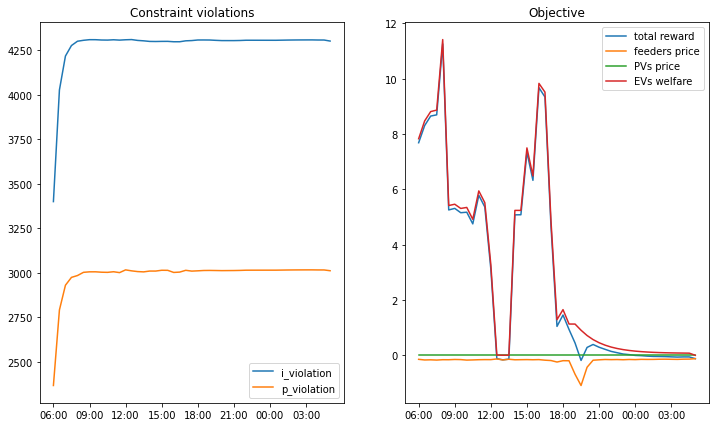

In [16]:
# Greedy heuristic which solves single-timestep OPF using lossless model
# It gets higher reward, but violates the power-flow constraints. 
env.use_rescaled_actions = True
env.normalize_outputs = False

np.random.seed(2204672)
env.reset(episode_index=24, train=True)

results_list = []
total_reward = 0
i_violations = 0
p_violations = 0

while not env.done:
    # print('t=%s' % env.t_str)
    action = np.array(actions[env.t_ind])
    _, _, _, result = env.step(action)
    total_reward += result['reward']
    i_violations += result['i_constraints_violation']
    p_violations += result['power_flow_constraints_violation']
    results_list.append(result)

print(env.t_ind, len(actions))
print('Reward = %.2f' % total_reward)
print(i_violations, p_violations)
plot_results(env, results_list, figsize=(12, 7))


# np.random.seed(9308507)
# env.reset(episode_index=35, train=True)

# p_lbs, p_ubs, v_lbs, v_ubs, u, evs_dict = env.compute_full_state()
# p_det, v_det, model = compute_deterministic_solution(env.dt_min, evs_dict, u[0], p_lbs[0], 
#                                                      p_ubs[0], v_lbs[0], v_ubs[0], 
#                                                      env.conductance_matrix, env.i_max_matrix,
#                                                      lossless=False, tee=False)
                                                     
# results_list = []
# total_reward = 0

# while not env.done:
#     action = np.concatenate((p_det[env.t_ind], v_det[env.t_ind]), axis=0)
#     _, _, _, result = env.step(action)

#     total_reward += result['reward']
#     results_list.append(result)

# print('Reward = %.2f' % total_reward)
# plot_results(env, results_list, figsize=(12, 7))

The goal of the project is to come up with an RL based method that computes nodal powers and voltages that maximize the objective while keeping the constraint violations small.  The above simulations use the benchmarks that you should be comparing to. Clearly, you want to beat the greedy heuristic , but you can't beat the deterministic planner as it is the absolute optimal solution (assuming known future).